Marcin Skic Ewa Solarska, Grupa 13 
# Generowanie nowych danych na przykładzie zbioru Chinese MNIST

## Importy i połączenie z dyskiem google

In [ ]:
from keras.datasets import mnist, fashion_mnist
from keras.layers import Dense, Flatten, GaussianNoise, Input, Reshape, Lambda, Conv2D, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import backend as K

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Wczytanie danych Chinese MNIST

### Pobranie obrazów z chmury

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/chinese_mnist.csv")

X = []
for index, row in df.iterrows():
    suite_id = row[1]
    sample_id = row[2]
    code = row[3]
    file_name = f"input_{suite_id}_{sample_id}_{code}.jpg"
    x = cv2.imread(f"/content/drive/MyDrive/data/{file_name}")
    if x is None: #Protection from files that should exist according to csv but don't
      print(file_name)
      continue
    X.append(x)
X = np.stack(X)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
input_1_12_100.jpg
input_10_12_100.jpg
input_2_12_100.jpg
input_3_12_100.jpg
input_4_12_100.jpg
input_5_12_100.jpg
input_6_12_100.jpg
input_7_12_100.jpg
input_8_12_100.jpg
input_9_12_100.jpg
input_1_12_100.jpg
input_10_12_100.jpg
input_2_12_100.jpg
input_3_12_100.jpg
input_4_12_100.jpg
input_5_12_100.jpg
input_6_12_100.jpg
input_7_12_100.jpg
input_8_12_100.jpg
input_9_12_100.jpg
input_1_12_100.jpg
input_10_12_100.jpg
input_2_12_100.jpg
input_3_12_100.jpg
input_4_12_100.jpg
input_5_12_100.jpg
input_6_12_100.jpg
input_7_12_100.jpg
input_8_12_100.jpg
input_9_12_100.jpg
input_1_12_100.jpg
input_10_12_100.jpg
input_2_12_100.jpg
input_3_12_100.jpg
input_4_12_100.jpg
input_5_12_100.jpg
input_6_12_100.jpg
input_7_12_100.jpg
input_8_12_100.jpg
input_9_12_100.jpg
input_1_12_100.jpg
input_10_12_100.jpg
input_2_12_100.jpg
input_3_12_100.jpg
input_4_12_100.jpg
input_5_12_100.jpg
input_6_12_100.jpg
input_7_12_100.jpg
input_8_12_100.jpg

### Manipulacja danymi

In [ ]:
X_temp = X.copy() #To preserve downloaded original
np.random.shuffle(X_temp) #By default it is ordered by symbols
X_train = X_temp[:8000,:,:,0]
X_test = X_temp[8000:,:,:,0]
X_train = X_train / 255 #For grayscale working in models
X_test = X_test / 255 #For grayscale working in models

## Autoenkoder

### Stworzenie modelu Autoenkodera

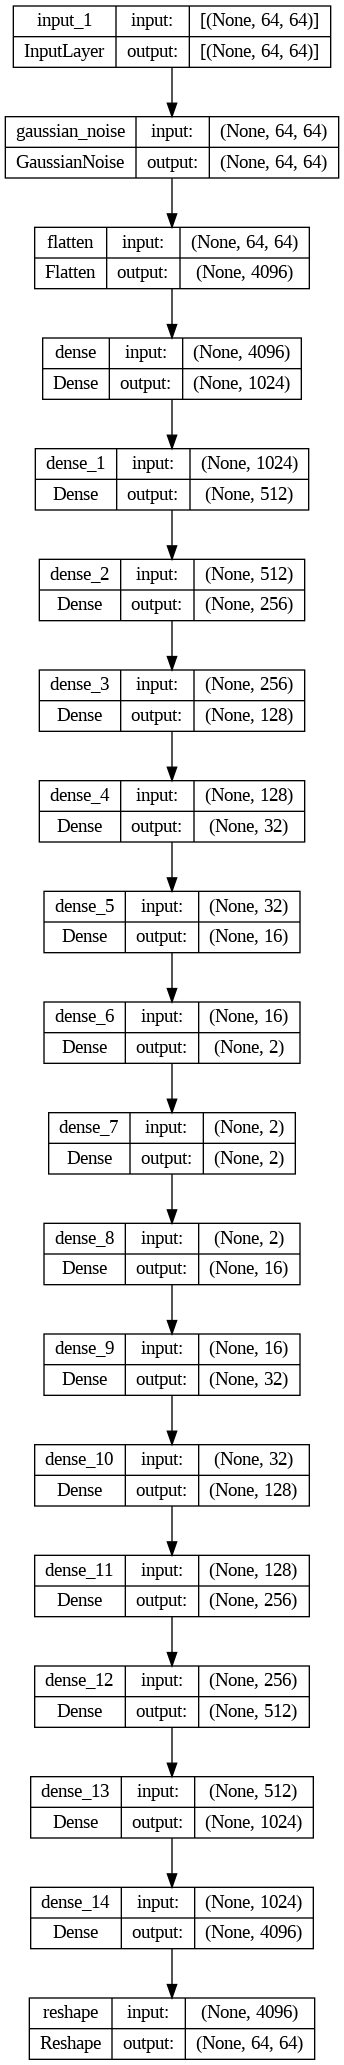

In [ ]:
act_func = 'selu'

encoder_layers = [
  GaussianNoise(1),
  Flatten(),
  Dense(1024, activation=act_func),
  Dense(512, activation=act_func),
  Dense(256, activation=act_func),
  Dense(128, activation=act_func),
  Dense(32, activation=act_func),
  Dense(16, activation=act_func),
  Dense(2, activation=act_func),
]
decoder_layers = [
  Dense(2, activation=act_func),
  Dense(16, activation=act_func),
  Dense(32, activation=act_func),
  Dense(128, activation=act_func),
  Dense(256, activation=act_func),
  Dense(512, activation=act_func),
  Dense(1024, activation=act_func),
  Dense(64*64, activation="sigmoid"),
  Reshape((64,64))
]
lrng_rate = 0.0001

tensor = input_aec = input_encoder = Input(X_train.shape[1:])
for layer in encoder_layers:
  tensor = layer(tensor)
output_encoder = tensor
dec_tensor = input_decoder =Input(output_encoder.shape[1:])
for layer in decoder_layers:
  tensor = layer(tensor)
  dec_tensor = layer(dec_tensor)
output_aec = tensor
output_decoder = dec_tensor
autoencoder = Model(inputs = input_aec,outputs = output_aec)
encoder = Model(inputs = input_encoder,outputs = output_encoder)
decoder = Model(inputs = input_decoder,outputs = dec_tensor)

autoencoder.compile(optimizer=Adam(lrng_rate),loss='binary_crossentropy')
plot_model(autoencoder,show_shapes=True)

### Trenowanie autoenkodera

In [ ]:
autoencoder.fit(x = X_train, y = X_train,epochs = 1000, batch_size = 256)

Epoch 1/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0336
Epoch 2/1000
32/32 [==============================] - 1s 34ms/step - loss: 0.0336
Epoch 3/1000
32/32 [==============================] - 1s 33ms/step - loss: 0.0337
Epoch 4/1000
32/32 [==============================] - 1s 33ms/step - loss: 0.0337
Epoch 5/1000
32/32 [==============================] - 3s 95ms/step - loss: 0.0335
Epoch 6/1000
32/32 [==============================] - 1s 20ms/step - loss: 0.0337
Epoch 7/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0337
Epoch 8/1000
32/32 [==============================] - 1s 41ms/step - loss: 0.0337
Epoch 9/1000
32/32 [==============================] - 2s 55ms/step - loss: 0.0336
Epoch 10/1000
32/32 [==============================] - 1s 33ms/step - loss: 0.0336
Epoch 11/1000
32/32 [==============================] - 1s 33ms/step - loss: 0.0337
Epoch 12/1000
32/32 [==============================] - 1s 33ms/step - loss: 0.0335
Epoch 13/1000

#### Ocena wykresu strat

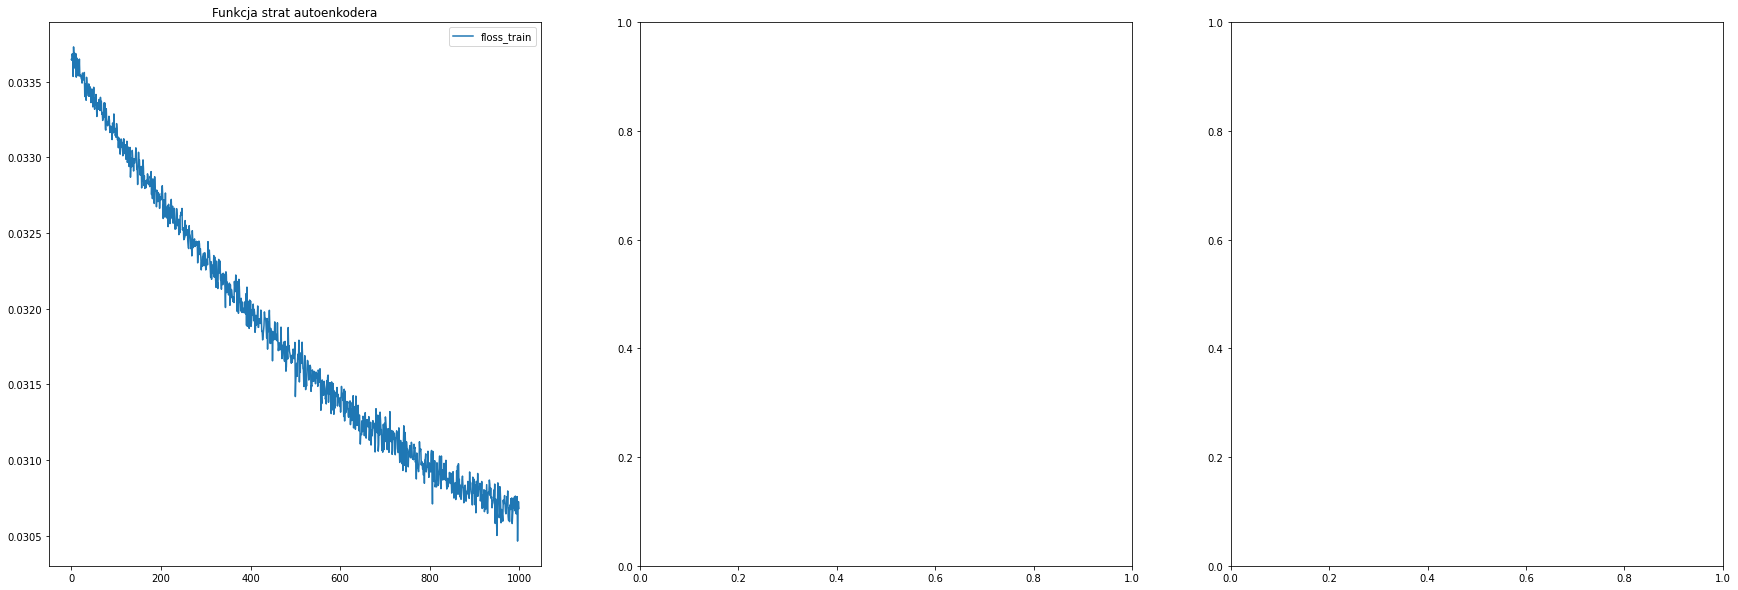

In [ ]:
auto_history = autoencoder.history.history
auto_floss_train = auto_history['loss']
fig,ax = plt.subplots(1,3, figsize=(30,10))



epochs = np.arange(0, 1000)
ax[0].plot(epochs, auto_floss_train, label = 'floss_train')
ax[0].set_title('Funkcja strat autoenkodera')
ax[0].legend()


#### I weryfikacja pracy

1/1 [==============================] - 0s 300ms/step


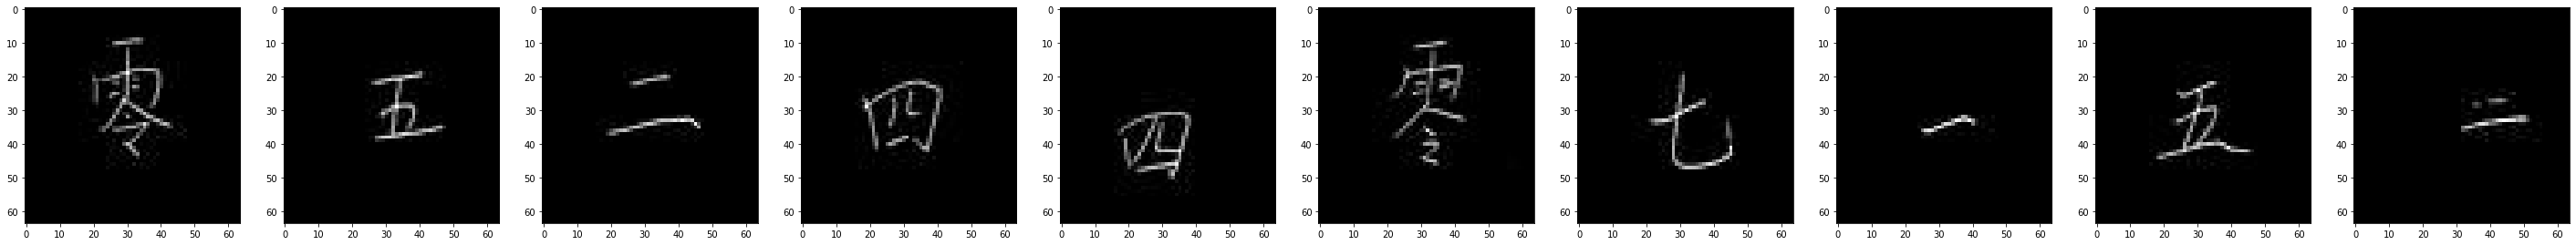

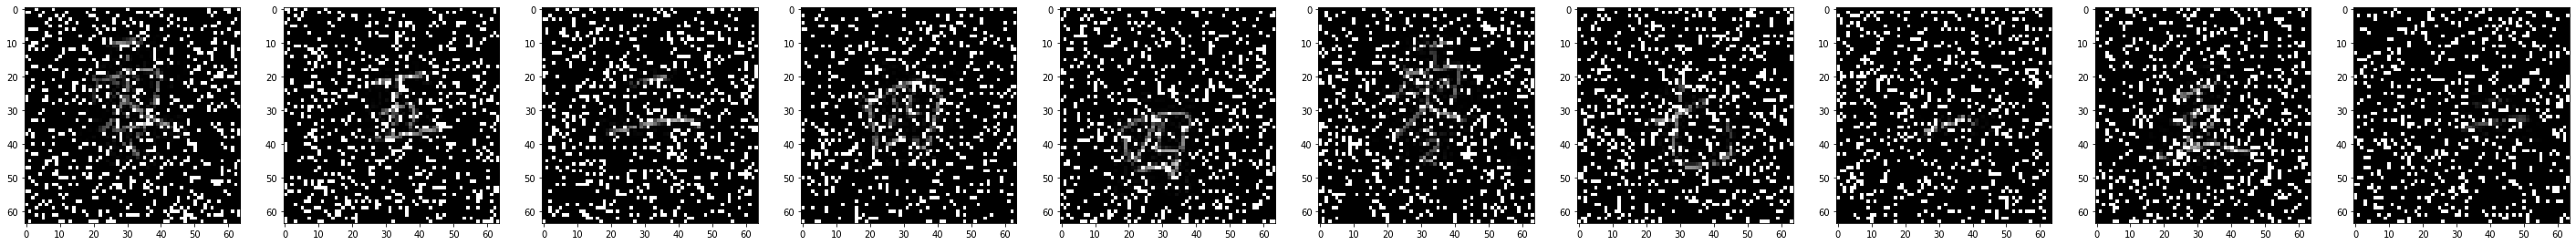

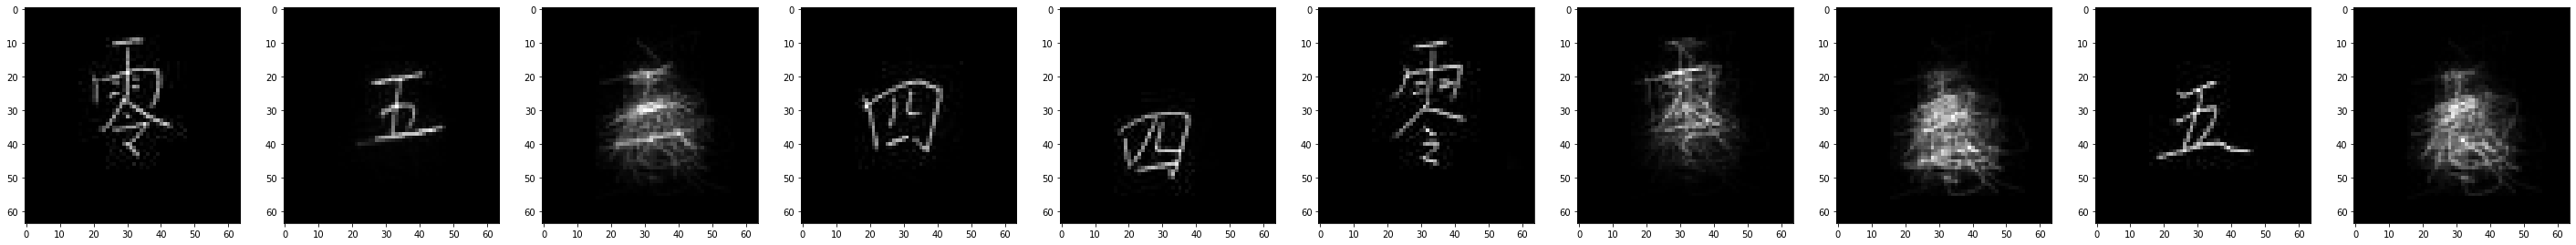

In [ ]:
def show_pictures(arrs):
  arr_cnt = arrs.shape[0]
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))
  for axis, pic in zip(axes, arrs):
    axis.imshow(pic.squeeze(), cmap = 'gray')

test_photos = X_test[10:20,...].copy()
mask = np.random.randn(*test_photos.shape)
white = mask > 1
black = mask < -1
noisy_test_photos=test_photos.copy()
noisy_test_photos[white] = 1
noisy_test_photos[black] = 0

cleaned_images=autoencoder.predict(noisy_test_photos)
show_pictures(test_photos)
show_pictures(noisy_test_photos)
show_pictures(cleaned_images)

### Generowanie nowych danych

1/1 [==============================] - 0s 13ms/step


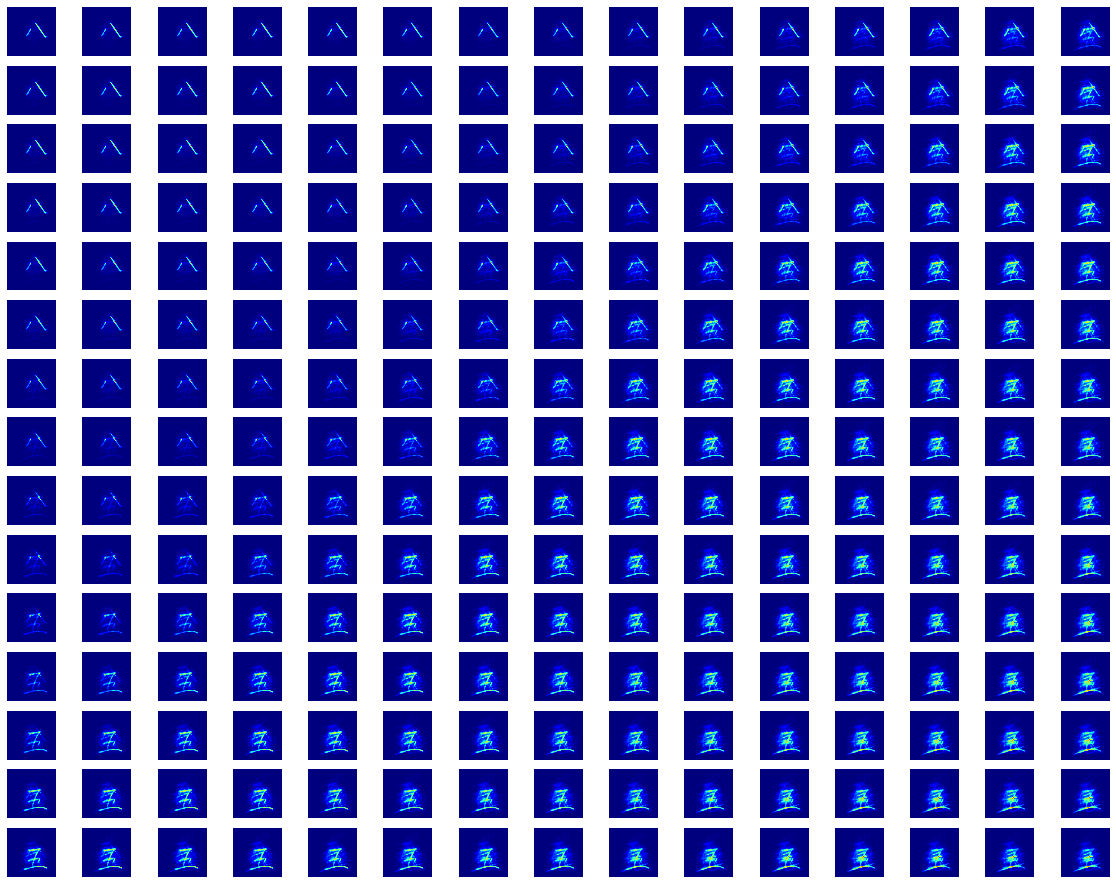

In [ ]:
num = 15
limit = 0.6
step = limit*2/num
fig, ax = plt.subplots(num, num, figsize = (20,16))
X_vals = np.arange(-limit, limit, step)
Y_vals = np.arange(-limit, limit, step)
for i, x in enumerate(X_vals):
  for j, y in enumerate(Y_vals):
    test_in = np.array([[x,y]])
    output = decoder.predict(x=test_in)
    output = np.squeeze(output)
    ax[-j-1,i].imshow(output, cmap = 'jet')
    ax[-j-1,i].axis('off')

## GAN - rywalizująca sieć generatywna


### Stworzenie modelu deskryptora

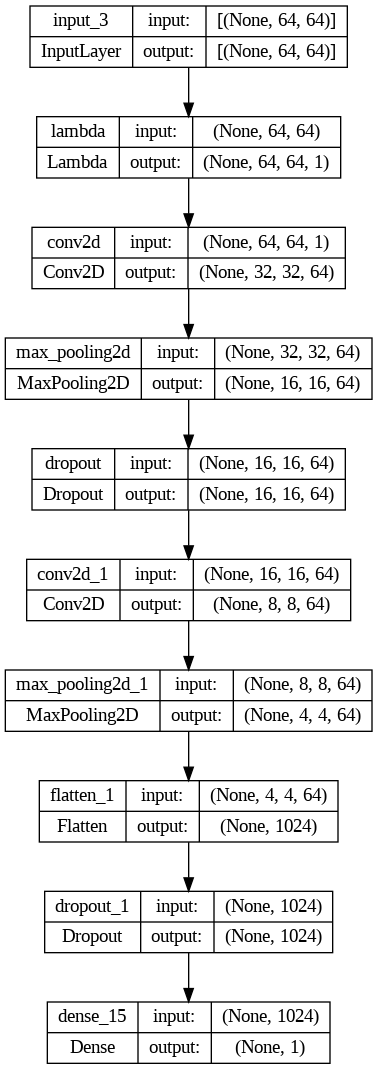

In [ ]:
act_f = 'relu'
descriptor_layers = [
    Lambda(lambda x: K.expand_dims(x, axis=-1)),
    Conv2D(64,(5,5),strides=(2,2),padding='same'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(64,(5,5),strides=(2,2),padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(1, 'sigmoid')]
descriptor_input = descriptor_output = Input(X_train.shape[1:])
for layer in descriptor_layers:
  descriptor_output = layer(descriptor_output)
descriptor = Model(inputs = descriptor_input,outputs = descriptor_output)
descriptor.compile(loss='BinaryCrossentropy',metrics='accuracy',optimizer=Adam(0.001, beta_1=0.8))

plot_model(descriptor, show_shapes=True)

### Stworzenie modelu generatora

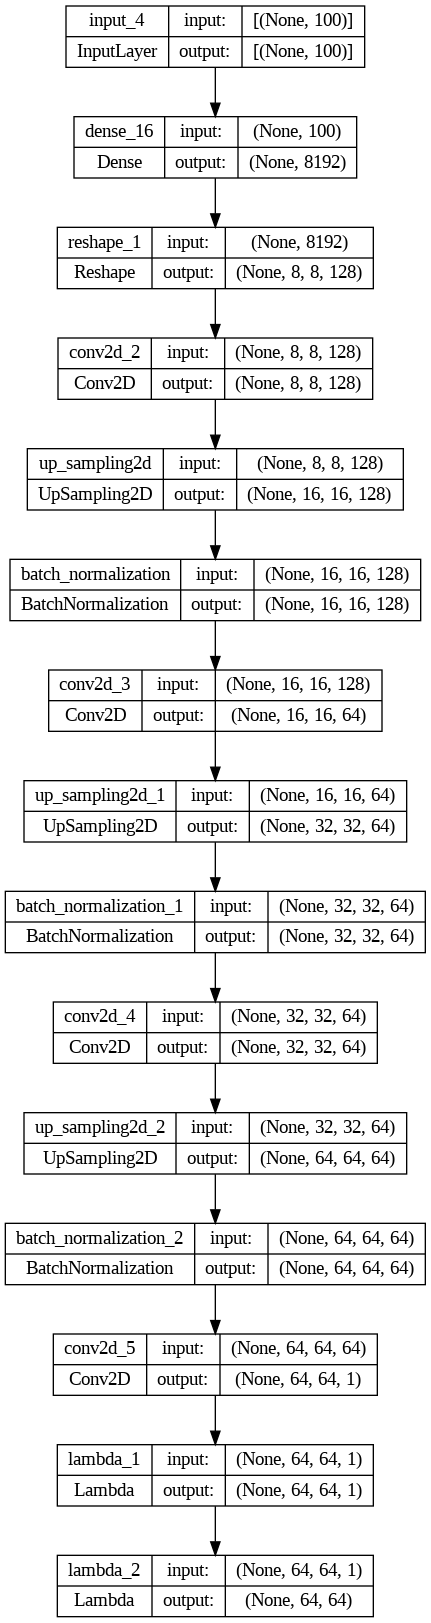

In [ ]:
act_f = 'selu'
hidden_dim = 100
channel_cnt = 128
generator_layers = [
  Dense(channel_cnt*8*8, activation=act_f),
  Reshape((8, 8, channel_cnt)),
  Conv2D(128,(5,5),padding='same',activation=act_f),
  UpSampling2D((2,2)),
  BatchNormalization(),
  Conv2D(64,(5,5),padding='same',activation=act_f),
  UpSampling2D((2,2)),
  BatchNormalization(),
  Conv2D(64,(5,5),padding='same',activation=act_f),
  UpSampling2D((2,2)),
  BatchNormalization(),
  Conv2D(1, kernel_size=(8,8),padding='same', activation='sigmoid'),
  Lambda(lambda x: x*255),
  Lambda(lambda x: K.squeeze(x, axis=-1))]
generator_input = generator_output = Input((hidden_dim,))
for layer in generator_layers:
  generator_output = layer(generator_output)
generator = Model(inputs = generator_input,outputs = generator_output)

plot_model(generator, show_shapes=True)

### Stworzenie modelu GAN

In [ ]:
gan = Model(inputs = generator.input,outputs = descriptor(generator.outputs))
descriptor.trainable = False
gan.compile(loss='BinaryCrossentropy',optimizer=Adam(0.0002, beta_1=0.8))

### Trenowanie i wyświetlenie wyników GAN

epoch 1 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 680ms/step
epoch 2 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 702ms/step
epoch 3 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step
epoch 4 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step
epoch 5 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 666ms/step
epoch 6 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 537ms/step
epoch 7 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step
epoch 8 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 266ms/step
epoch 9 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step
epoch 10 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 112ms/step
epoch 11 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch 12 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step
epoch 13 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step
epoch 14 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 290ms/step
epoch 15 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 581ms/step
epoch 16 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step
epoch 17 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 524ms/step
epoch 18 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
epoch 19 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 553ms/step
epoch 20 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 680ms/step
epoch 21 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 333ms/step


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


epoch 22 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
epoch 23 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step
epoch 24 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 395ms/step
epoch 25 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 531ms/step
epoch 26 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step
epoch 27 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 117ms/step


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


epoch 28 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 313ms/step
epoch 29 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
epoch 30 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step
epoch 31 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 309ms/step
epoch 32 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
epoch 33 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


epoch 34 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 126ms/step
epoch 35 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 444ms/step
epoch 36 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 118ms/step


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


epoch 37 of 40


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 575ms/step
epoch 38 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 194ms/step
epoch 39 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 268ms/step
epoch 40 of 40


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 395ms/step


<ipython-input-18-67e7c418b433>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))


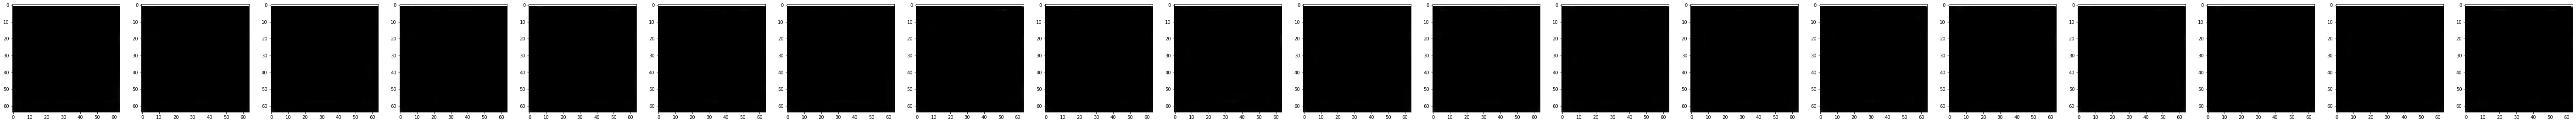

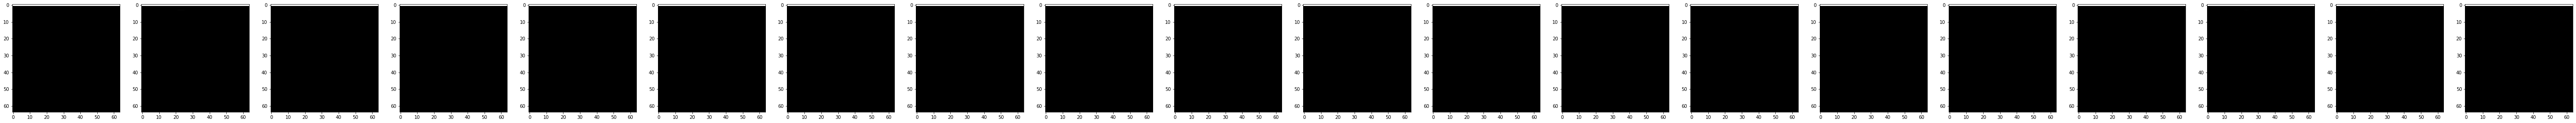

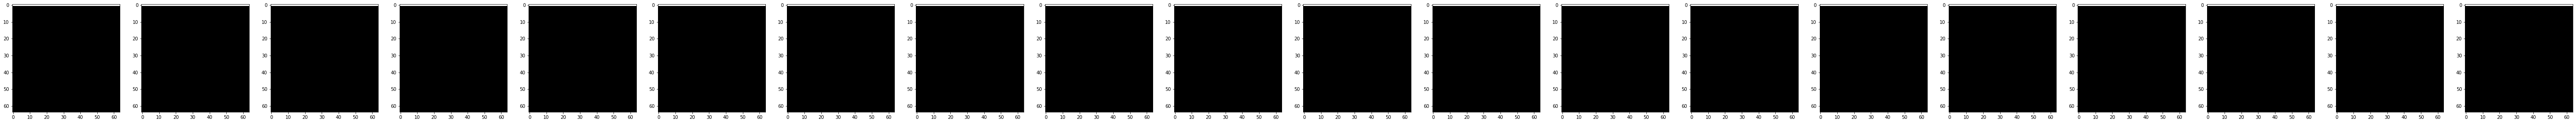

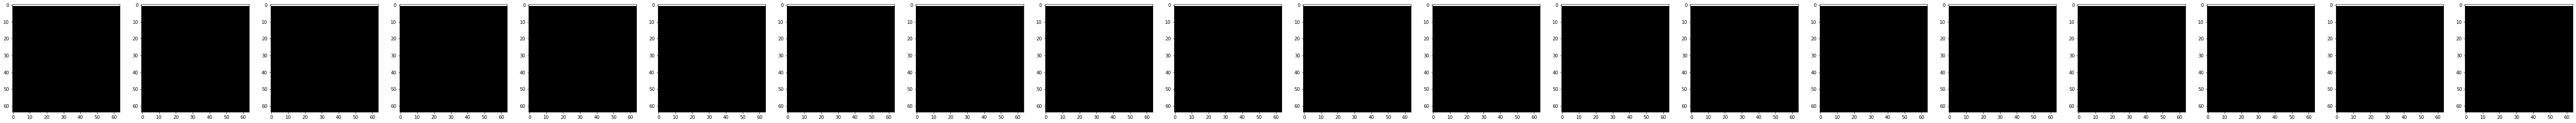

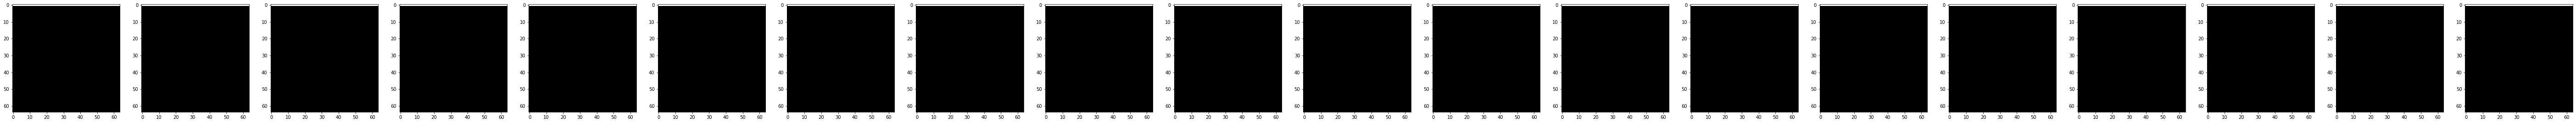

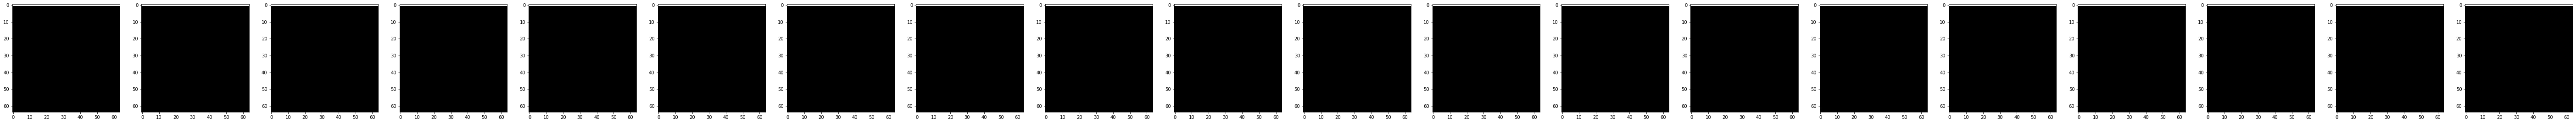

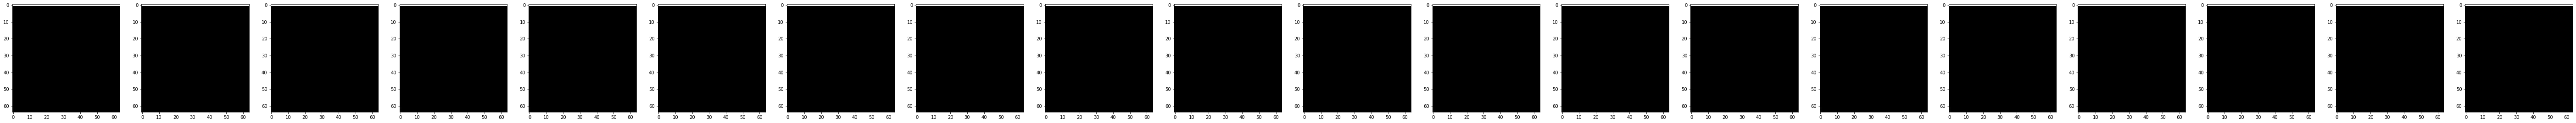

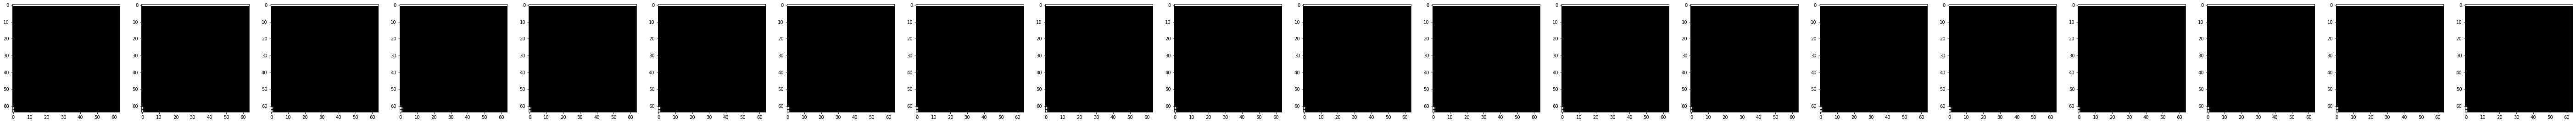

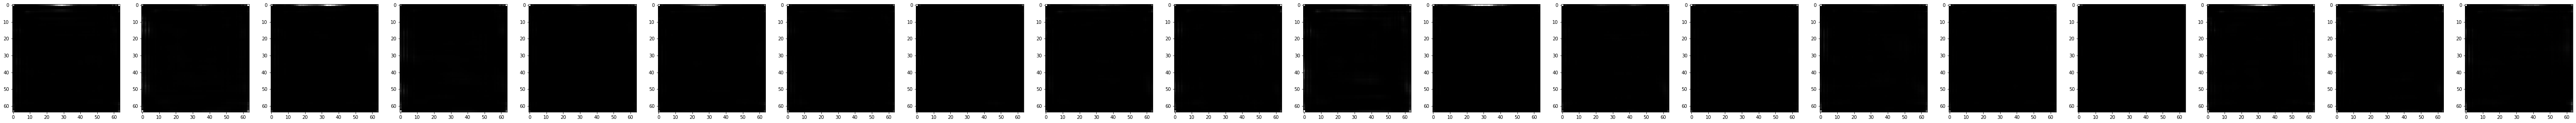

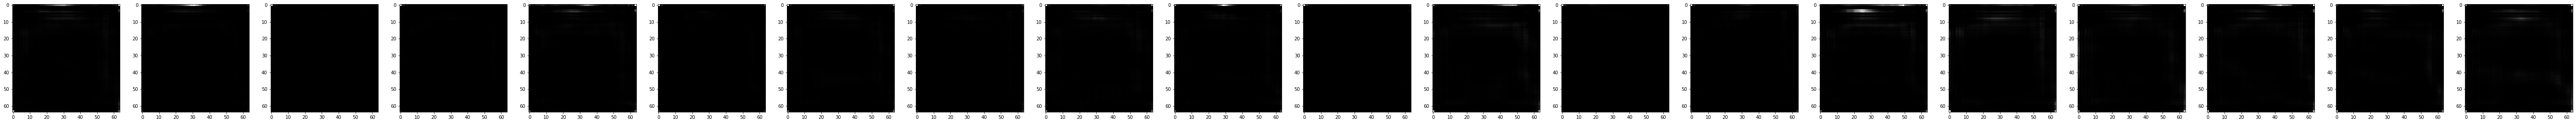

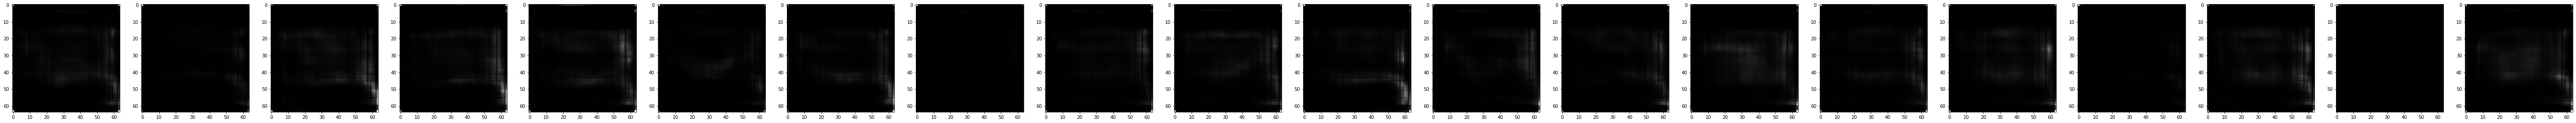

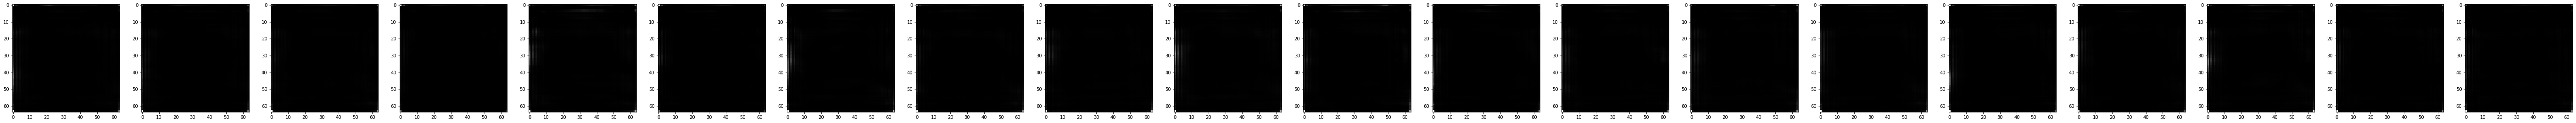

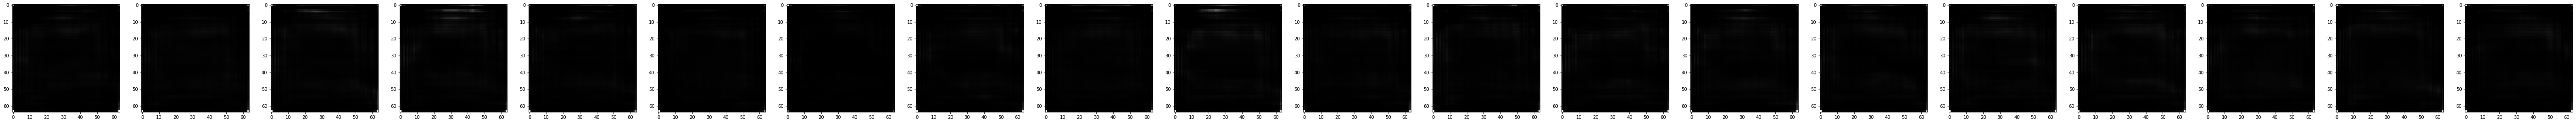

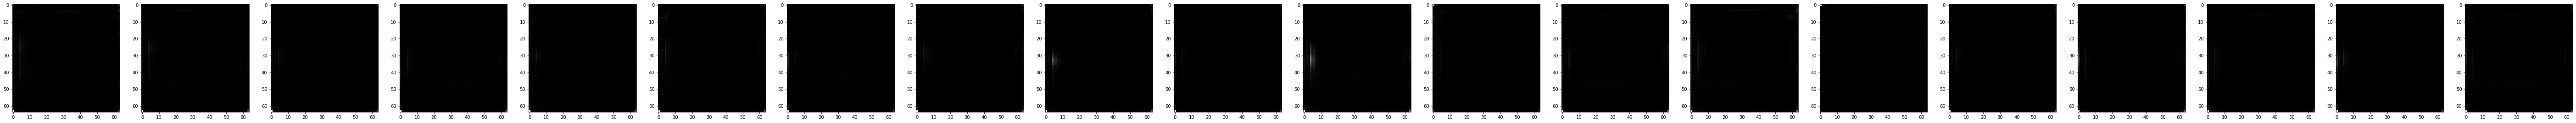

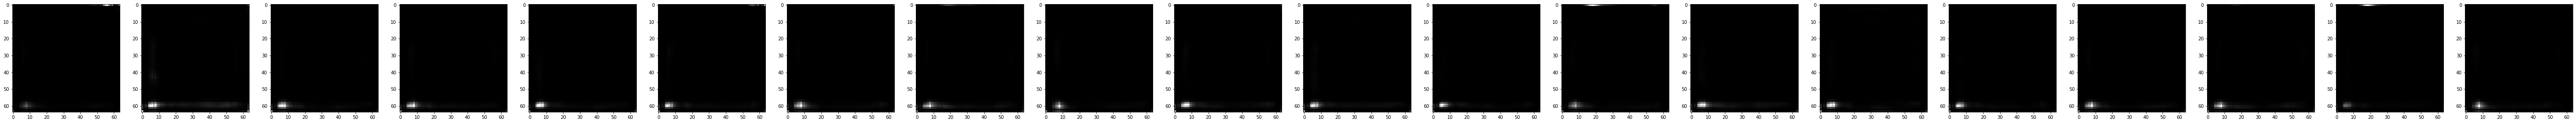

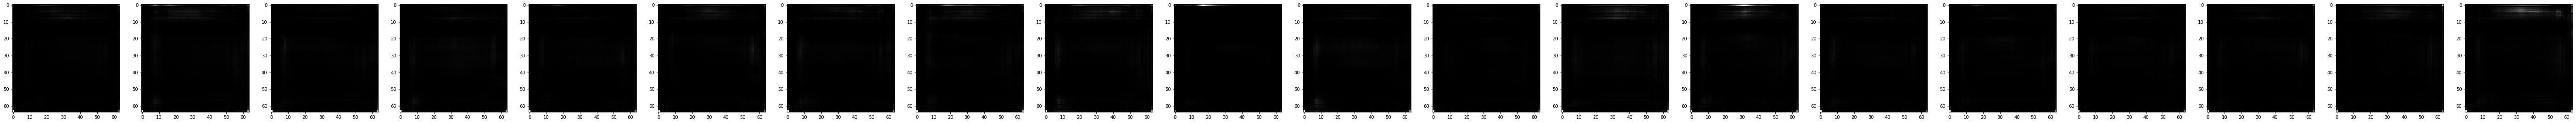

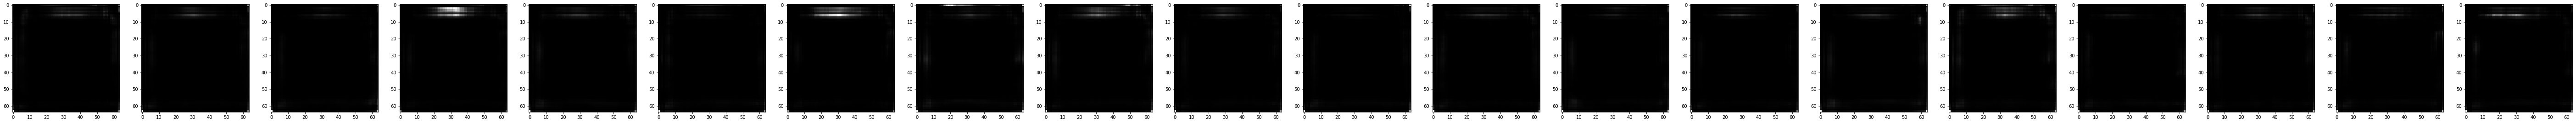

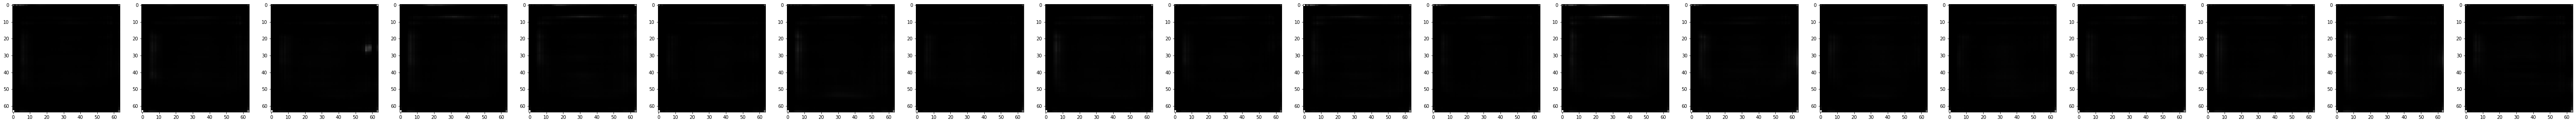

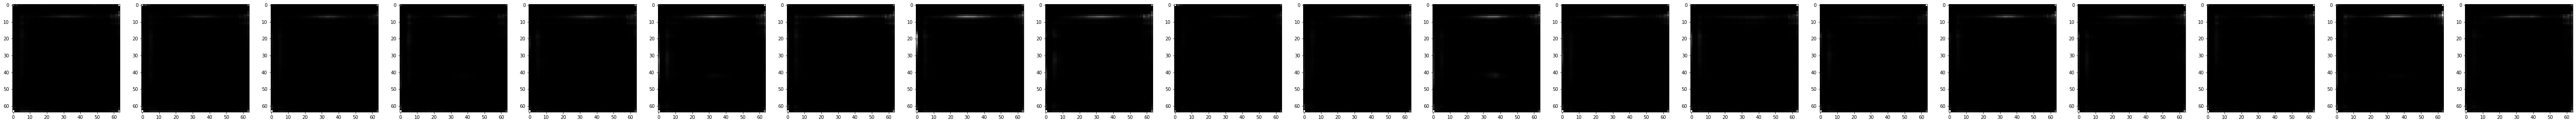

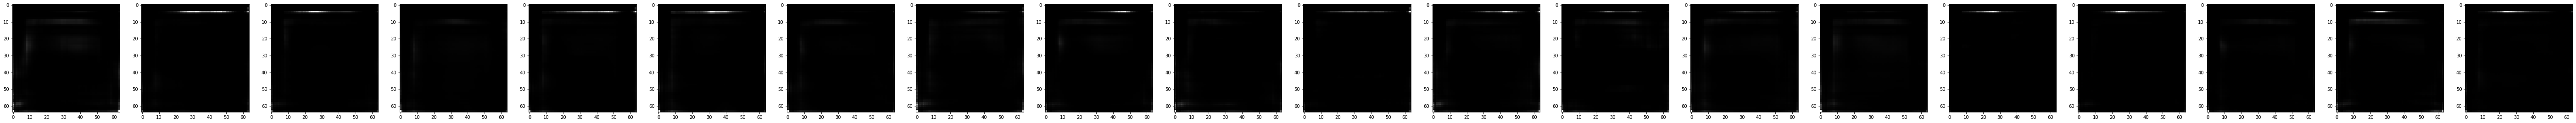

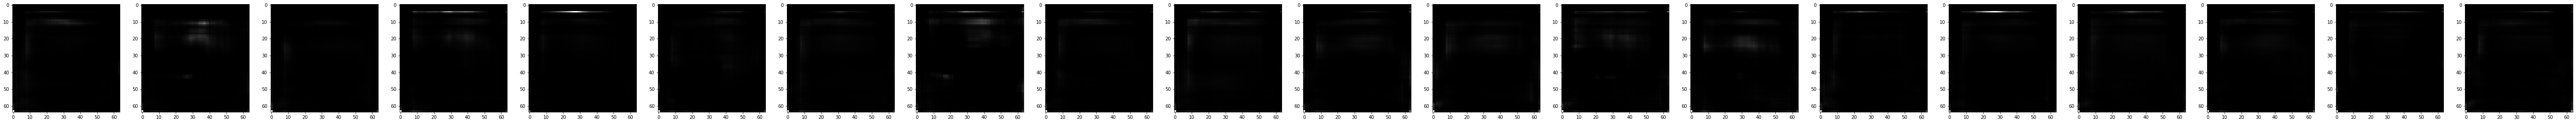

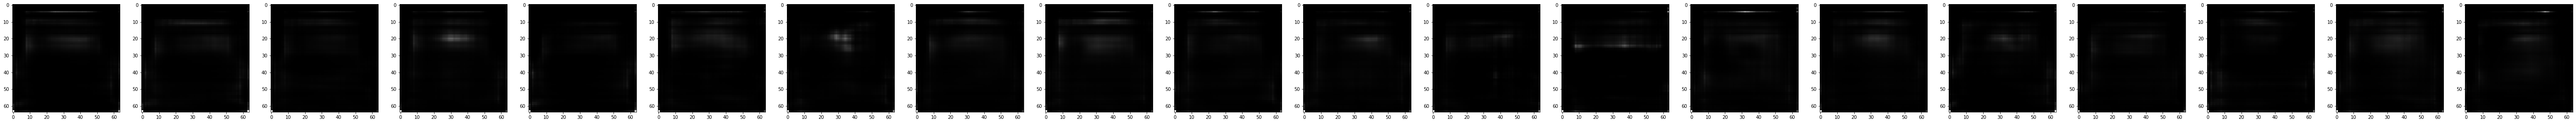

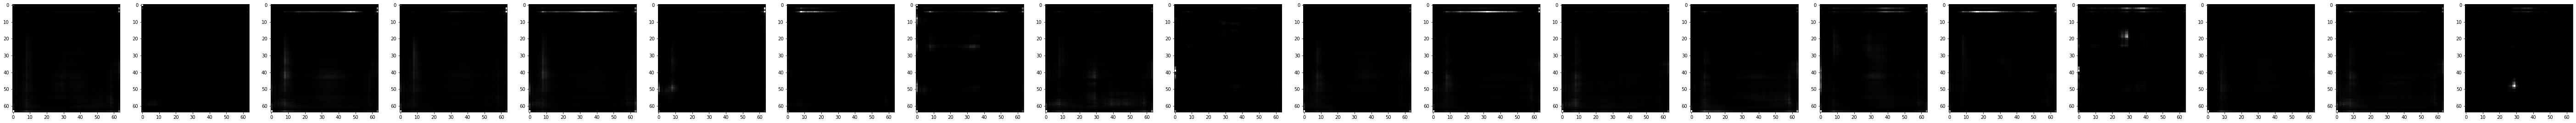

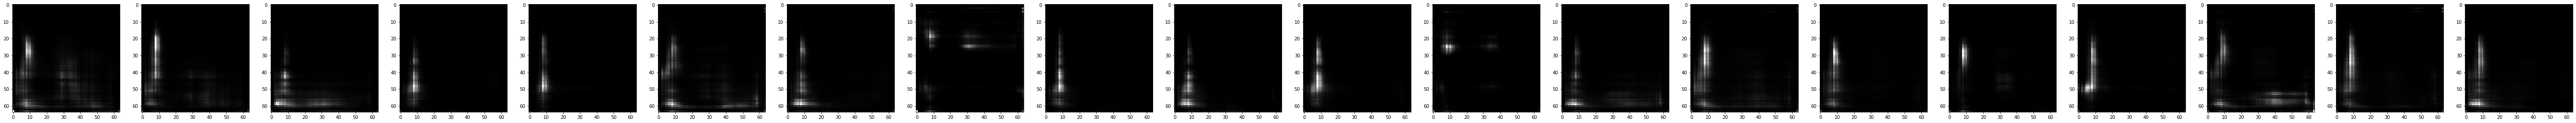

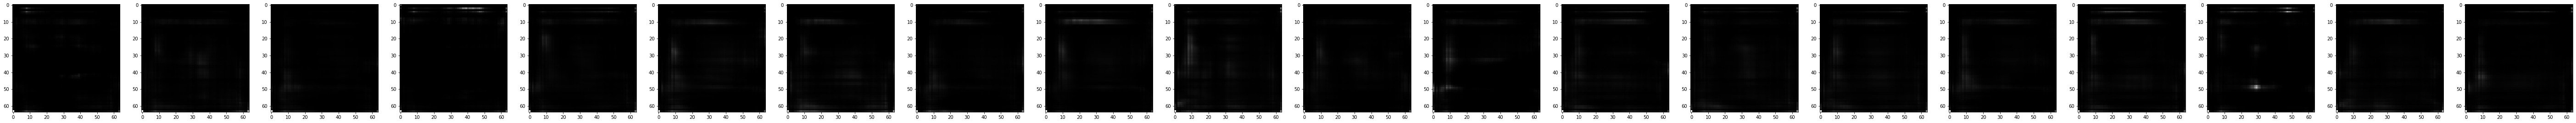

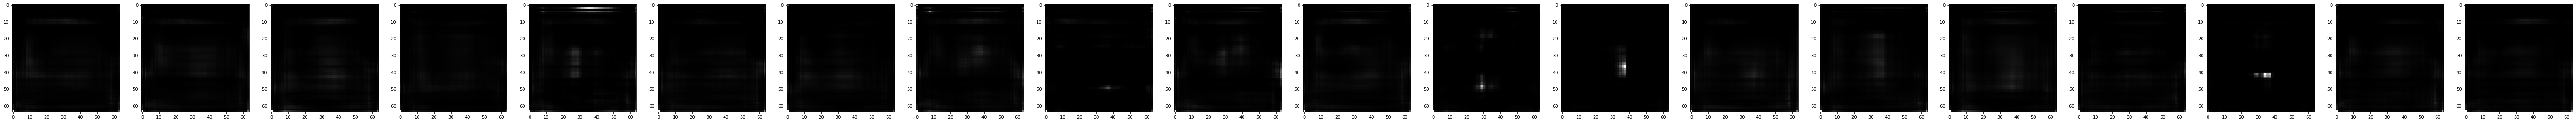

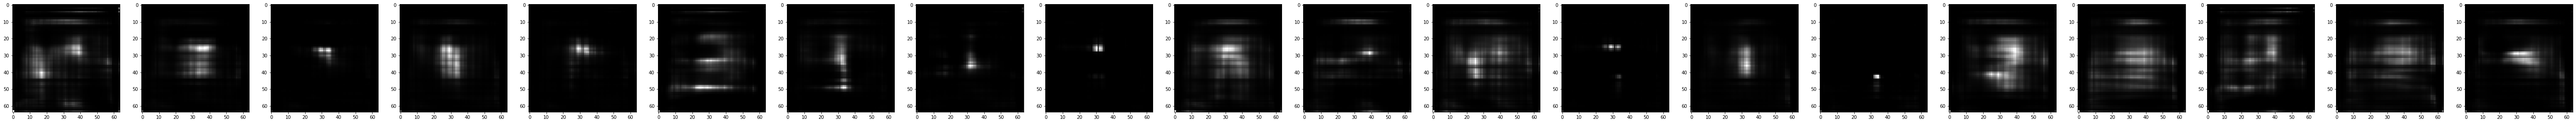

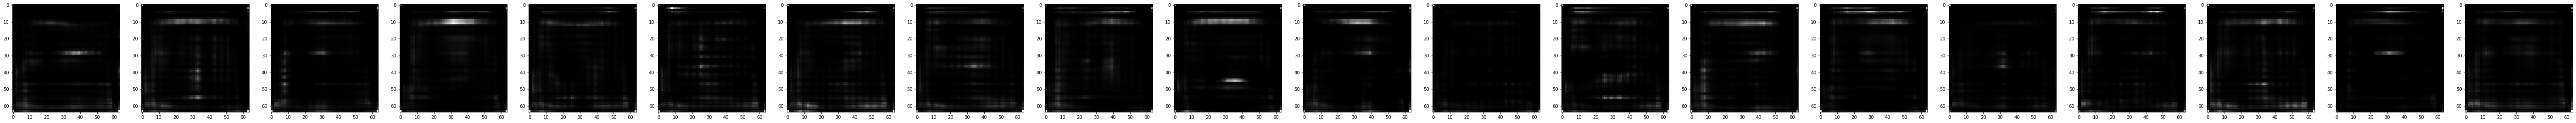

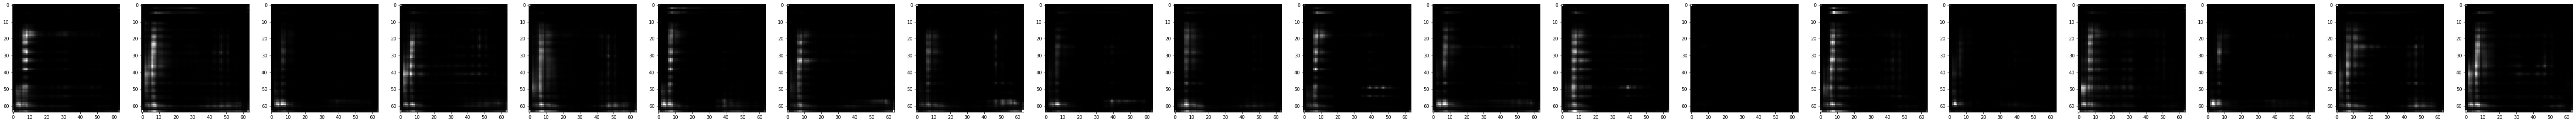

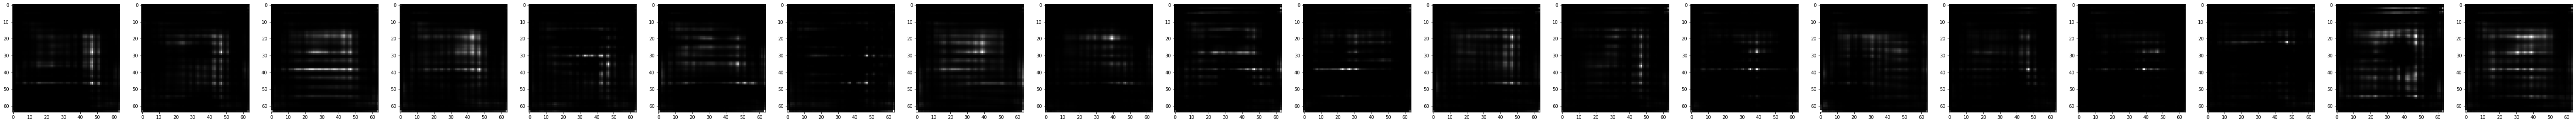

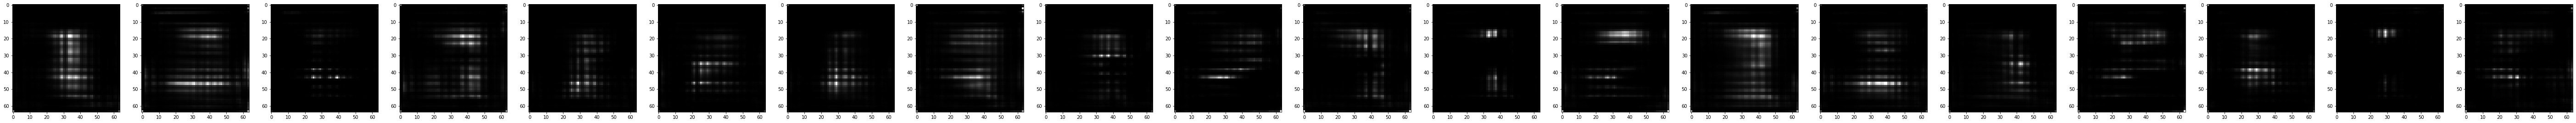

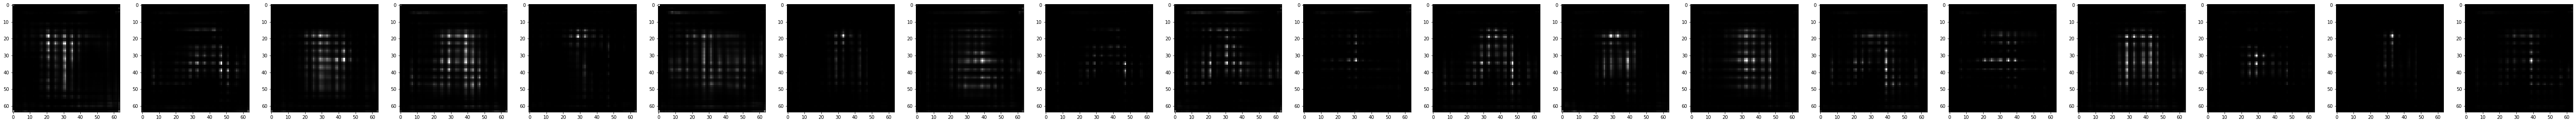

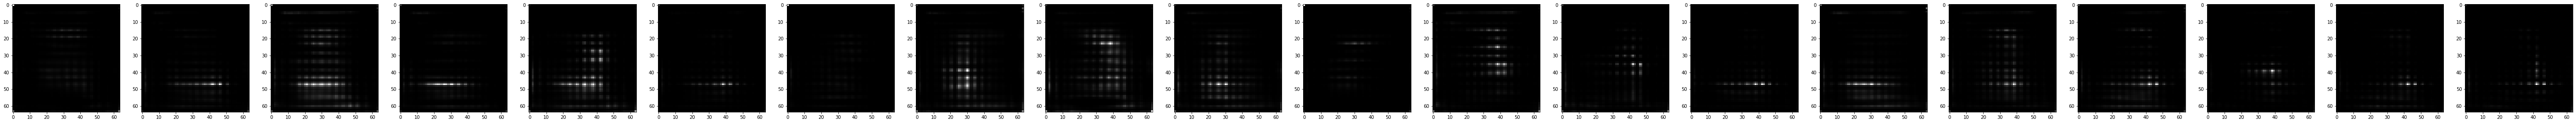

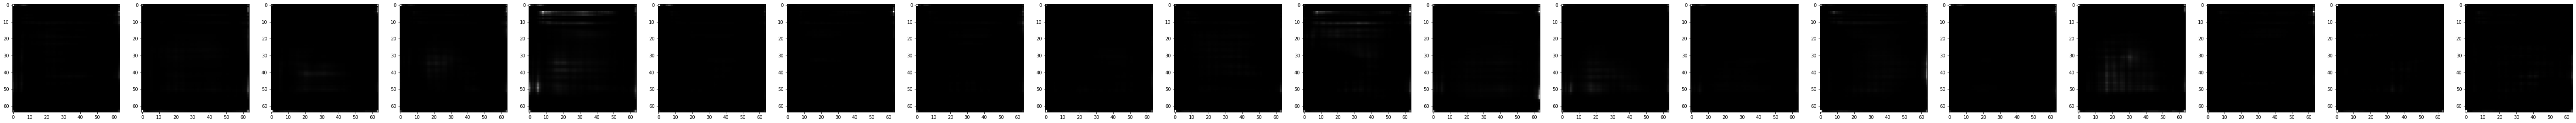

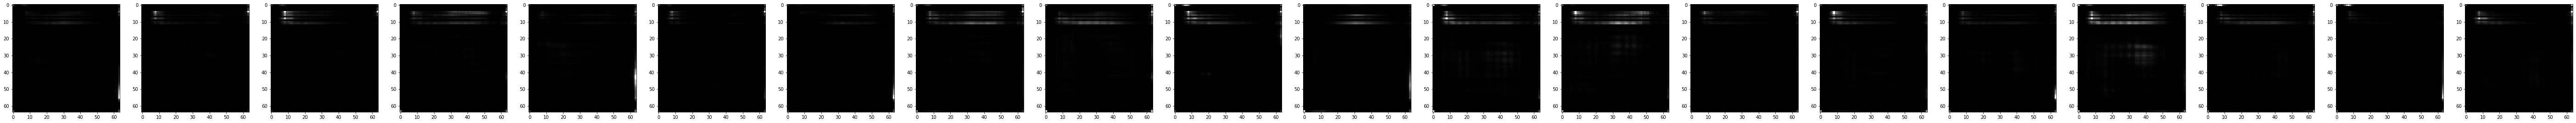

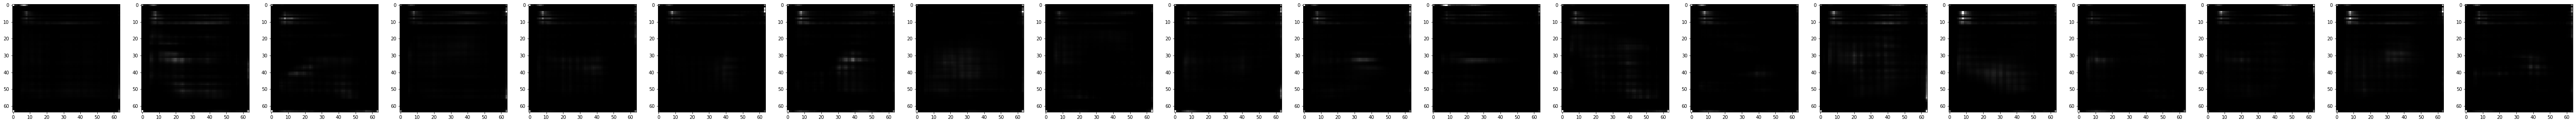

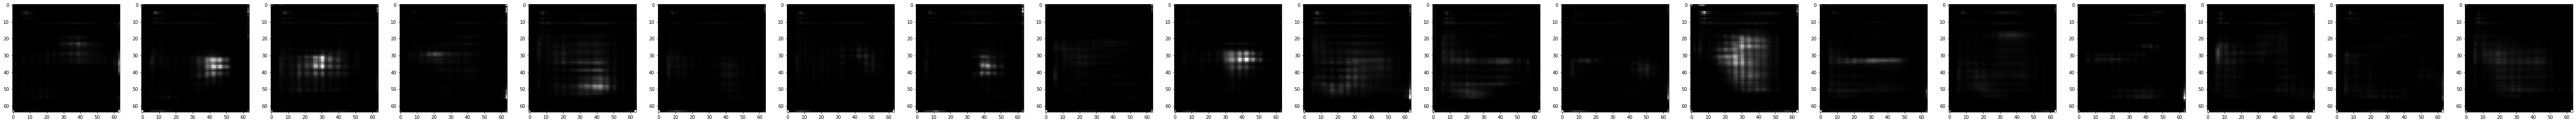

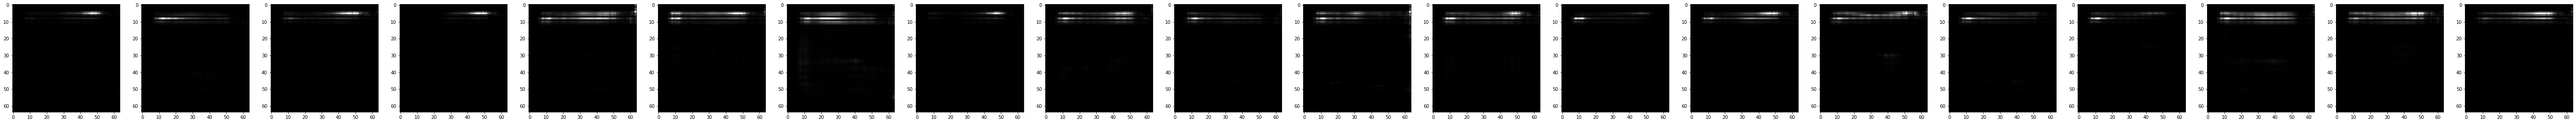

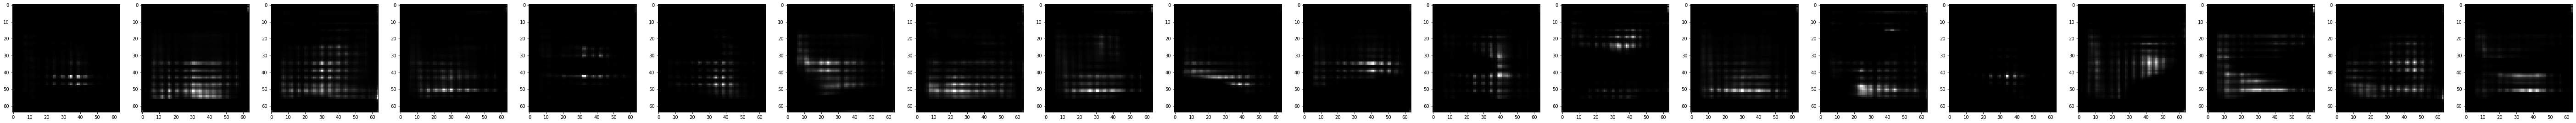

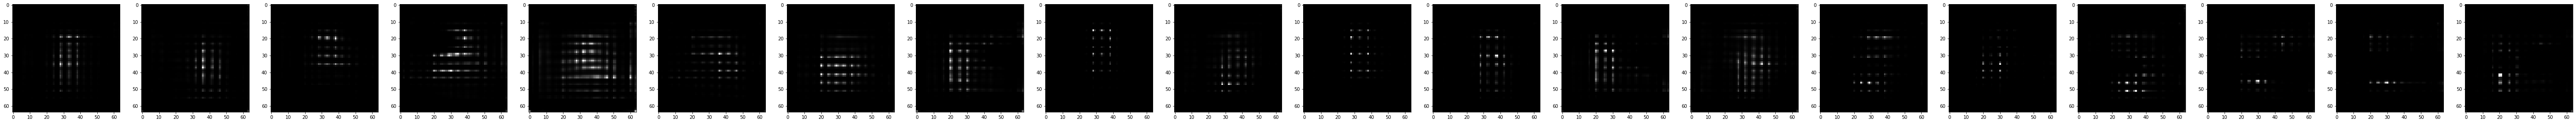

In [ ]:
def show_pictures(arrs):
  arr_cnt = arrs.shape[0]
  fig, axes = plt.subplots(1, arr_cnt,figsize=(5*arr_cnt, arr_cnt))
  for axis, pic in zip(axes, arrs):
    axis.imshow(pic.squeeze(), cmap = 'gray')

def make_train_batch(X_train,batch_size,batch_num,hidden_dim,generator):
  noise=tf.random.normal([batch_size,hidden_dim])
  X_train_real = X_train[batch_num*batch_size:(batch_num+1)*batch_size,:].copy()
  X_train_fake = generator(noise,training=True)
  y_train_real = np.repeat(1,X_train_real.shape[0])
  y_train_fake = np.repeat(0,X_train_fake.shape[0])
  X_all = np.concatenate([X_train_real,X_train_fake])
  y_all = np.concatenate([y_train_real,y_train_fake])
  return (X_all, y_all)

def generate_images(img_cnt, hidden_dim, generator):
  noise = tf.random.normal([img_cnt,hidden_dim])
  result = generator.predict(noise)
  return result

from tqdm.notebook import tqdm
epoch_cnt = 40
img_cnt = X_train.shape[0]
batch_size = 200
for i in range(epoch_cnt):
  print(f'epoch {i+1} of {epoch_cnt}')
  for batch in tqdm(range(batch_size)):
    X_all, y_all = make_train_batch(X_train,batch_size,batch, hidden_dim, generator)
    descriptor.train_on_batch(X_all, y_all)
    X_gan = np.random.randn(batch_size*2,hidden_dim)
    y_gan = np.ones((batch_size*2,))
    gan.train_on_batch(X_gan, y_gan)
  generated_images = generate_images(20, hidden_dim,generator)
  show_pictures(generated_images)